# Project 3: Web APIs & Classification

General Assembly DSI 19 Project 3 Adrian Teng 

# Project Introduction

1. Using Reddit's API to collect posts from two subreddits of your choosing.
2. NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

# Problem Statement

We  hypothesis that by having two similar text-driven subreddits, as NLP will have a difficult time spotting the difference between the 2 subreddits. As there are over 1.5 million subreddits on reddit, we will be be classifying post from two subreddits that are heavily text driven, 'tifu' and 'confessions' respectively. 

We will be creating and comparing models: a logistic regression, a multinomial naive Bayes, a KNeighborsClassifier. The results obtained may be useful for reddit user who wants to submit his new post in the most optimal subreddit, so that he can attract more 'Upvotes' and 'Total rewards'.

# Executive Summary

In this project, it is splitted into three parts respectively:
- API & EDA (01_api_eda)
- Processing & Modeling (02_processing_modeling)
- Conclusion (03_conclusion)

In the first notebook, 01_api_eda, data was scrapped from Reddit. After gathering the raw data from the Reddit, exploration was done and new dataframe was created to better match the selection of models. Data cleaning was done, and duplicates was removed to strengthen the effectiveness of the project. At the end, TfidVectorizer and Logistic Regression was decided, based on their accuracy result.


## Content
- Data Scarpping 
- EDA
- Data Cleaning



# Notebook 1: API AND EDA

In [6]:
#Library imports

import requests
import numpy as np
import time
import pandas as pd
import random
import ast #convert string data to indexable list of dicts
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

### Data Scrapping

In [ ]:
#define both subreddits url
url_1 = 'https://www.reddit.com/r/tifu.json'
url_2 = 'https://www.reddit.com/r/confessions.json'

In [ ]:
#set new headers 
headers = {'User-agent': 'testtest12345'}

In [ ]:
#get data from both websites 
res_1 = requests.get(url_1, headers=headers)
res_2 = requests.get(url_2, headers=headers)

In [ ]:
#use json for the data collected
the_json_1 = res_1.json()
the_json_2 = res_2.json()

In [ ]:
#collect 1000 'after' with a loop for first url
after_1 = None
posts_1 = []
url_1_pages = []
url_1 = ''
for _ in range(40):                       #every 1 loop, will obtain 25posts
    print(f'Scraping {(_+1)*25} posts.')
    if after_1 == None :
        params = {}
        url_1 = f"https://www.reddit.com/r/tifu.json"
    else:
        params = {'after':after_1}
        url_1 = f"https://www.reddit.com/r/tifu.json?after={params['after']}"  # to obtain the next 25 posts
    res_1 = requests.get(url_1, params=params, headers=headers)
    if res_1.status_code == 200:
        the_json_1 = res_1.json()
        posts_1.extend(the_json_1['data']['children'])
        after_1 = the_json_1['data']['after']
        print(after_1)
        url_1_pages.append(res_1.json()['data'])     #add the data into url_1_pages
        print('url_1_pages length: ', len(url_1_pages))
    else:
        print(f'Error code: {res_1.status_code}.')
        break
    time.sleep(1)              #adding a delay when pulling data from reddit

In [ ]:
len(posts_1)

In [ ]:
# repeating the same loop for url 2
after_2 = None
posts_2 = []
url_2_pages = []
url_2 = ''
for _ in range(40):
    print(f'Scraping {(_+1)*25} posts.')
    if after_2 == None :
        params = {}
        url_2 = f'https://www.reddit.com/r/confessions.json'
    else:
        params = {'after':after_2}
        url_2 = f"https://www.reddit.com/r/confessions.json?after={params['after']}"
    res_2 = requests.get(url_2, params=params, headers=headers)
    if res_2.status_code == 200:
        the_json_2 = res_2.json()
        posts_2.extend(the_json_2['data']['children'])
        after_2 = the_json_2['data']['after']
        print(after_2)
        url_2_pages.append(res_2.json()['data'])
        print('url_2_pages length: ', len(url_2_pages))
    else:
        print(f'Error code: {res_2.status_code}.')
        break
    time.sleep(1)

In [ ]:
len(posts_2)

In [ ]:
#change the url_1/2_pages list into dataframe
tifu_df = pd.DataFrame(url_1_pages)
confessions_df = pd.DataFrame(url_2_pages)

In [ ]:
tifu_df

In [ ]:
#saving the dataframe as csv file
tifu_df.to_csv('../datasets/tifu_post.csv', index = False, header = True)
confessions_df.to_csv('../datasets/confessions_post.csv', index = False, header = True)

### EDA

Open the original API data just scrapped

In [7]:
#read the new csv files saved
tifu_posts = pd.read_csv('../datasets/tifu_post.csv')
confessions_posts = pd.read_csv('../datasets/confessions_post.csv')

In [8]:
confessions_posts.head()

,modhash,dist,children,after,before
0,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_ku9txr,NaN
1,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kuxjbb,NaN
2,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kv2ilw,NaN
3,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_ku9x43,NaN
4,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_ktzqoq,NaN


In [9]:
tifu_posts.head()

,modhash,dist,children,after,before
0,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kuz8j2,NaN
1,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kuv7nm,NaN
2,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kucrkx,NaN
3,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_ku2pil,NaN
4,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kud2zn,NaN


In [10]:
#converting strings of dicts back into dicts stored in active notebook memory using literial_aval

tifu_posts['children'] = tifu_posts.children.map(lambda x: ast.literal_eval(x))

In [11]:
#converting strings of dicts back into dicts stored in active notebook memory using literial_aval

confessions_posts['children'] = confessions_posts.children.map(lambda x: ast.literal_eval(x))

In [12]:
tifu_posts.head()

,modhash,dist,children,after,before
0,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kuz8j2,NaN
1,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kuv7nm,NaN
2,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kucrkx,NaN
3,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_ku2pil,NaN
4,NaN,25,"[{'kind': 't3', 'data': {'approved_at_utc': No...",t3_kud2zn,NaN


In [13]:
tifu_posts.shape

(40, 5)

In [14]:
confessions_posts.shape

(40, 5)

In [15]:
#saving post dicts in arrays
tf_posts_b = tifu_posts['children']
cfns_posts_b = confessions_posts['children']

In [16]:
tf_posts_b.head()

0    [{'kind': 't3', 'data': {'approved_at_utc': No...
1    [{'kind': 't3', 'data': {'approved_at_utc': No...
2    [{'kind': 't3', 'data': {'approved_at_utc': No...
3    [{'kind': 't3', 'data': {'approved_at_utc': No...
4    [{'kind': 't3', 'data': {'approved_at_utc': No...
Name: children, dtype: object

In [17]:
cfns_posts_b.head()

0    [{'kind': 't3', 'data': {'approved_at_utc': No...
1    [{'kind': 't3', 'data': {'approved_at_utc': No...
2    [{'kind': 't3', 'data': {'approved_at_utc': No...
3    [{'kind': 't3', 'data': {'approved_at_utc': No...
4    [{'kind': 't3', 'data': {'approved_at_utc': No...
Name: children, dtype: object

In [18]:
#Print the number of posts

for post in tf_posts_b:
    print(len(post))

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
20
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


### Looking deeper into 'data'

#### Targeted Fields
- Title: 'title'
- Posts: 'selftext'
- Author: 'author_fullname'
- Upvotes: 'ups'
- Down: 'downs'
- Total Rewards: 'total_awards_received'

In [19]:
tf_posts_b[0][0]['data']

{'approved_at_utc': None,
 'subreddit': 'tifu',
 'selftext': 'Not a long story but as a new years resolution I told myself I would make an effort to compliment people because it always makes me feel good when I receive one.\nSo this woman comes in and she\'s really nice and friendly and as I\'m making her coffee we are having a chat and she has this huge belt that is absolutely covered in those sparkly jewel thingies. So I say. "I really like your belt it\'s really shiny" she smiles and says "thanks" so I go. "I wish I could pull it off" not thinking that it could mean something else other than I wish it looked good on me. she blushes and looks down and when I finish her coffee she looks at me and smiles and says "thanks" so my assistant manager comes over and she\'s like "did you just tell her you wanted to take her belt off?" My face goes red as I realise what I said. I explained it to my assistant manager who just laughed and told me to think about what i say before I say it \n\nTl;

In [20]:
tf_posts_b[0][0]['data']['selftext']

'Not a long story but as a new years resolution I told myself I would make an effort to compliment people because it always makes me feel good when I receive one.\nSo this woman comes in and she\'s really nice and friendly and as I\'m making her coffee we are having a chat and she has this huge belt that is absolutely covered in those sparkly jewel thingies. So I say. "I really like your belt it\'s really shiny" she smiles and says "thanks" so I go. "I wish I could pull it off" not thinking that it could mean something else other than I wish it looked good on me. she blushes and looks down and when I finish her coffee she looks at me and smiles and says "thanks" so my assistant manager comes over and she\'s like "did you just tell her you wanted to take her belt off?" My face goes red as I realise what I said. I explained it to my assistant manager who just laughed and told me to think about what i say before I say it \n\nTl;dr complimented a customer on her belt and told her I wish I 

In [21]:
cfns_posts_b[0][0]['data']['selftext']

"I recently became homeless two months ago. I tried SO hard not to become homeless but I was a bartender and obviously my industry has been hit hard by covid. \n\nI feel humiliated. I have no family since last year when my mother passed away other than a father who pretends I don't exist...  With everyone struggling I have no friends I can turn too and it's so embarrassing to me. I don't want anyone to even know. i'm so cold all the time. Im so hungry. And im just tired. All day I've just thought of how to kill myself and it seems like a relief if I could.  I see no way out of this and my job gave me only 3 shifts this week. I just don't care anymore... I just want to be warm. I just ..  I give up. I just give up.  I'd give anything to be warm for a night. To be able to eat.  I can't do it anymore. Im trying so hard to find a new job but.. I can't even shower. I've been cleaning up in my work bathroom and im terrified they know.  I just want it to end. I want to not have to worry about

In [22]:
tf_posts_b[0][0]['data']['author_fullname']

't2_3q0ykzzz'

In [23]:
cfns_posts_b[0][0]['data']['author_fullname']

't2_95vgtyl1'

In [24]:
tf_posts_b[0][0]['data']['ups']

4869

In [25]:
tf_posts_b[0][24]['data']['downs']

0

In [26]:
cfns_posts_b[0][0]['data']['ups']

2927

In [27]:
cfns_posts_b[0][0]['data']['downs']

0

### Collecting the post attributes

Each subbreddit post batch (sized 25 posts) was iterate though the loop to return the value from each attribute's key

In [28]:
tf_titles = [tf_posts_b[j][k]['data']['title'] for j in range(len(tf_posts_b))
                for k in range (len(tf_posts_b[j]))]
                         
cfns_titles = [cfns_posts_b[j][k]['data']['title'] for j in range(len(cfns_posts_b))
                for k in range (len(cfns_posts_b[j]))]

In [29]:
tf_posts = [tf_posts_b[j][k]['data']['selftext'] for j in range(len(tf_posts_b))
                for k in range (len(tf_posts_b[j]))]
                         
cfns_posts = [cfns_posts_b[j][k]['data']['selftext'] for j in range(len(cfns_posts_b))
                for k in range (len(cfns_posts_b[j]))]

In [30]:
tf_posts = [tf_posts_b[j][k]['data']['selftext'] for j in range(len(tf_posts_b))
                for k in range (len(tf_posts_b[j]))]
                         
cfns_posts = [cfns_posts_b[j][k]['data']['selftext'] for j in range(len(cfns_posts_b))
                for k in range (len(cfns_posts_b[j]))]

In [31]:
tf_ups = [tf_posts_b[j][k]['data']['ups'] for j in range(len(tf_posts_b))
                for k in range (len(tf_posts_b[j]))]
                         
cfns_ups = [cfns_posts_b[j][k]['data']['ups'] for j in range(len(cfns_posts_b))
                for k in range (len(cfns_posts_b[j]))]

In [32]:
tf_tr = [tf_posts_b[j][k]['data']['total_awards_received'] for j in range(len(tf_posts_b))
                for k in range (len(tf_posts_b[j]))]
                         
cfns_tr = [cfns_posts_b[j][k]['data']['total_awards_received'] for j in range(len(cfns_posts_b))
                for k in range (len(cfns_posts_b[j]))]

In [33]:
tf_downs = [tf_posts_b[j][k]['data']['downs'] for j in range(len(tf_posts_b))
                for k in range (len(tf_posts_b[j]))]
                         
cfns_downs = [cfns_posts_b[j][k]['data']['downs'] for j in range(len(cfns_posts_b))
                for k in range (len(cfns_posts_b[j]))]

In [34]:
tf_authors = [] # empty lists to store results
cfns_authors = []

for j in range(len(tf_posts_b)): # for each post (size 25)
    for k in range(len(tf_posts_b[j])): # for each post in each scrape
        try:
            tf_authors.append(tf_posts_b[j][k]['data']['author_fullname']) # attempt to add to list
        except:
            tf_authors.append('no author') # if it fails, add text stating 'no author'
            
for j in range(len(cfns_posts_b)): # for each post in each scrape
    for k in range(len(cfns_posts_b[j])): # for each individual post
        try:
            cfns_authors.append(cfns_posts_b[i][j]['data']['author_fullname']) # attempt to add to list
        except:
            cfns_authors.append('no author') # if it fails, add instead 'no author'

In [35]:
#mean of upvotes in 'tifu'
mean_tf_ups = sum(tf_ups)/len(tf_ups)
mean_tf_ups

1139.0753768844222

In [45]:
#mean of upvotes in 'confessions'
mean_cfns_ups = sum(cfns_ups)/len(cfns_ups)
mean_cfns_ups

88.95175879396984

In [37]:
#mean of total rewards in 'tifu'
mean_tf_tr = sum(tf_tr)/len(tf_tr)
mean_tf_tr

5.154773869346734

In [38]:
#mean of total rewards in 'confession'
mean_cfns_tr = sum(cfns_tr)/len(cfns_tr)
mean_cfns_tr

0.4793969849246231

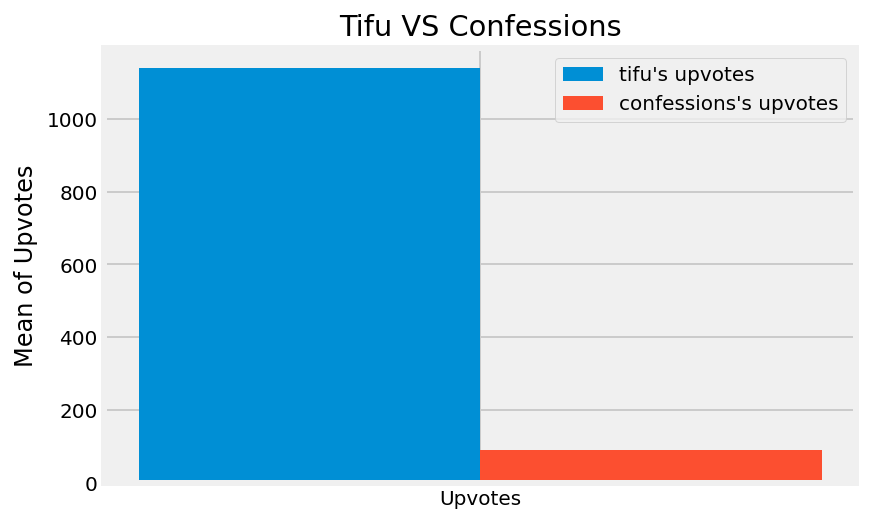

In [46]:
labels = ['Upvotes']
tifu_means = [mean_tf_ups]
cfns_means = [mean_cfns_ups]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tifu_means, width, label="tifu's upvotes")
rects2 = ax.bar(x + width/2, cfns_means, width, label="confessions's upvotes")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean of Upvotes')
ax.set_title('Tifu VS Confessions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

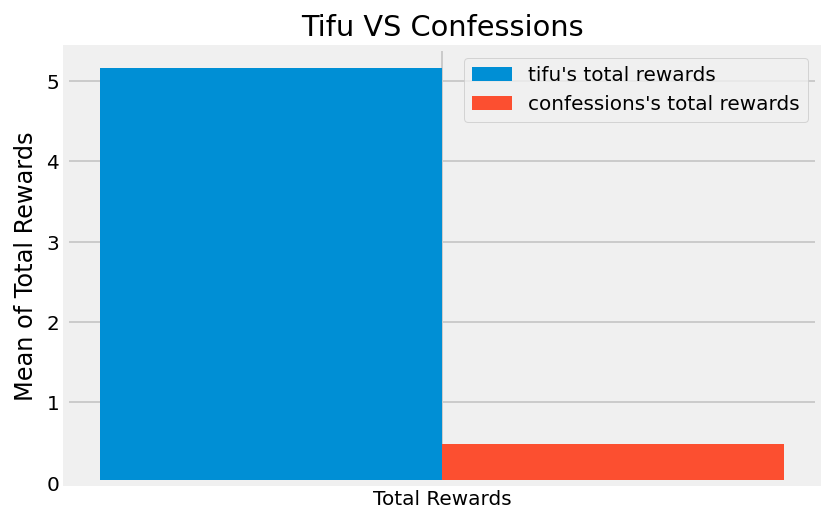

In [40]:
labels = ['Total Rewards']
tifu_means = [mean_tf_tr]
cfns_means = [mean_cfns_tr]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tifu_means, width, label="tifu's total rewards")
rects2 = ax.bar(x + width/2, cfns_means, width, label="confessions's total rewards")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean of Total Rewards')
ax.set_title('Tifu VS Confessions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

From the bar chart, we can deduced that 'tifu' is around 5 times higher in getting 'upvotes' and 'total rewards' as compared to a similar subreddits 'confessions'.

In [49]:
#print top 20 words in tf_posts
cvec = CountVectorizer(stop_words='english')
cvec.fit(tf_posts)

len_features = len(cvec.get_feature_names())
print(len_features)

tf_posts_cv = pd.DataFrame(cvec.transform(tf_posts).todense(),columns=cvec.get_feature_names())

top_tf = tf_posts_cv.sum(axis=0)
top_tf.sort_values(ascending = False).head(20)

12139


just        1799
like        1334
time         998
didn         976
got          936
dr           791
tl           779
really       736
know         733
went         730
said         634
day          591
thought      589
going        582
don          581
ve           572
happened     533
today        499
did          487
started      467
dtype: int64

In [54]:
# get top words in tf_posts

df_top_tf = top_tf.to_frame(name='count')
df_top_tf['word'] = df_top_tf.index
df_top_tf.reset_index(drop=True, inplace=True)
df_top_tf['freq'] = df_top_tf['count'] / len(tf_posts) * 100

cols = ['word','count','freq']
df_top_tf = df_top_tf[cols]
df_top_tf.sort_values(by='count',ascending=False, inplace=True)
df_top_tf.head(10)

,word,count,freq
5833,just,1799,180.804020
6154,like,1334,134.070352
10890,time,998,100.301508
2985,didn,976,98.090452
4651,got,936,94.070352
3263,dr,791,79.497487
10924,tl,779,78.291457
8483,really,736,73.969849
5934,know,733,73.668342
11827,went,730,73.366834


In [50]:
#print top 20 words in cfns_posts
cvec = CountVectorizer(stop_words='english')
cvec.fit(cfns_posts)

len_features = len(cvec.get_feature_names())
print(len_features)

cfns_posts_cv = pd.DataFrame(cvec.transform(cfns_posts).todense(),columns=cvec.get_feature_names())

top_cfns = cfns_posts_cv.sum(axis=0)
top_cfns.sort_values(ascending = False).head(20)

9774


just       1077
like        962
don         744
know        644
feel        589
want        504
ve          504
time        496
really      488
people      429
life        370
didn        351
think       351
got         335
years       308
friends     297
did         283
day         263
started     256
said        253
dtype: int64

In [55]:
# get top words in cfns_posts

df_top_cfns = top_cfns.to_frame(name='count')
df_top_cfns['word'] = df_top_cfns.index
df_top_cfns.reset_index(drop=True, inplace=True)
df_top_cfns['freq'] = df_top_cfns['count'] / len(tf_posts) * 100

cols = ['word','count','freq']
df_top_cfns = df_top_cfns[cols]
df_top_cfns.sort_values(by='count',ascending=False, inplace=True)
df_top_cfns.head(10)

,word,count,freq
4790,just,1077,108.241206
5077,like,962,96.683417
2657,don,744,74.773869
4881,know,644,64.723618
3306,feel,589,59.195980
9419,want,504,50.653266
9285,ve,504,50.653266
8812,time,496,49.849246
6974,really,488,49.045226
6300,people,429,43.115578


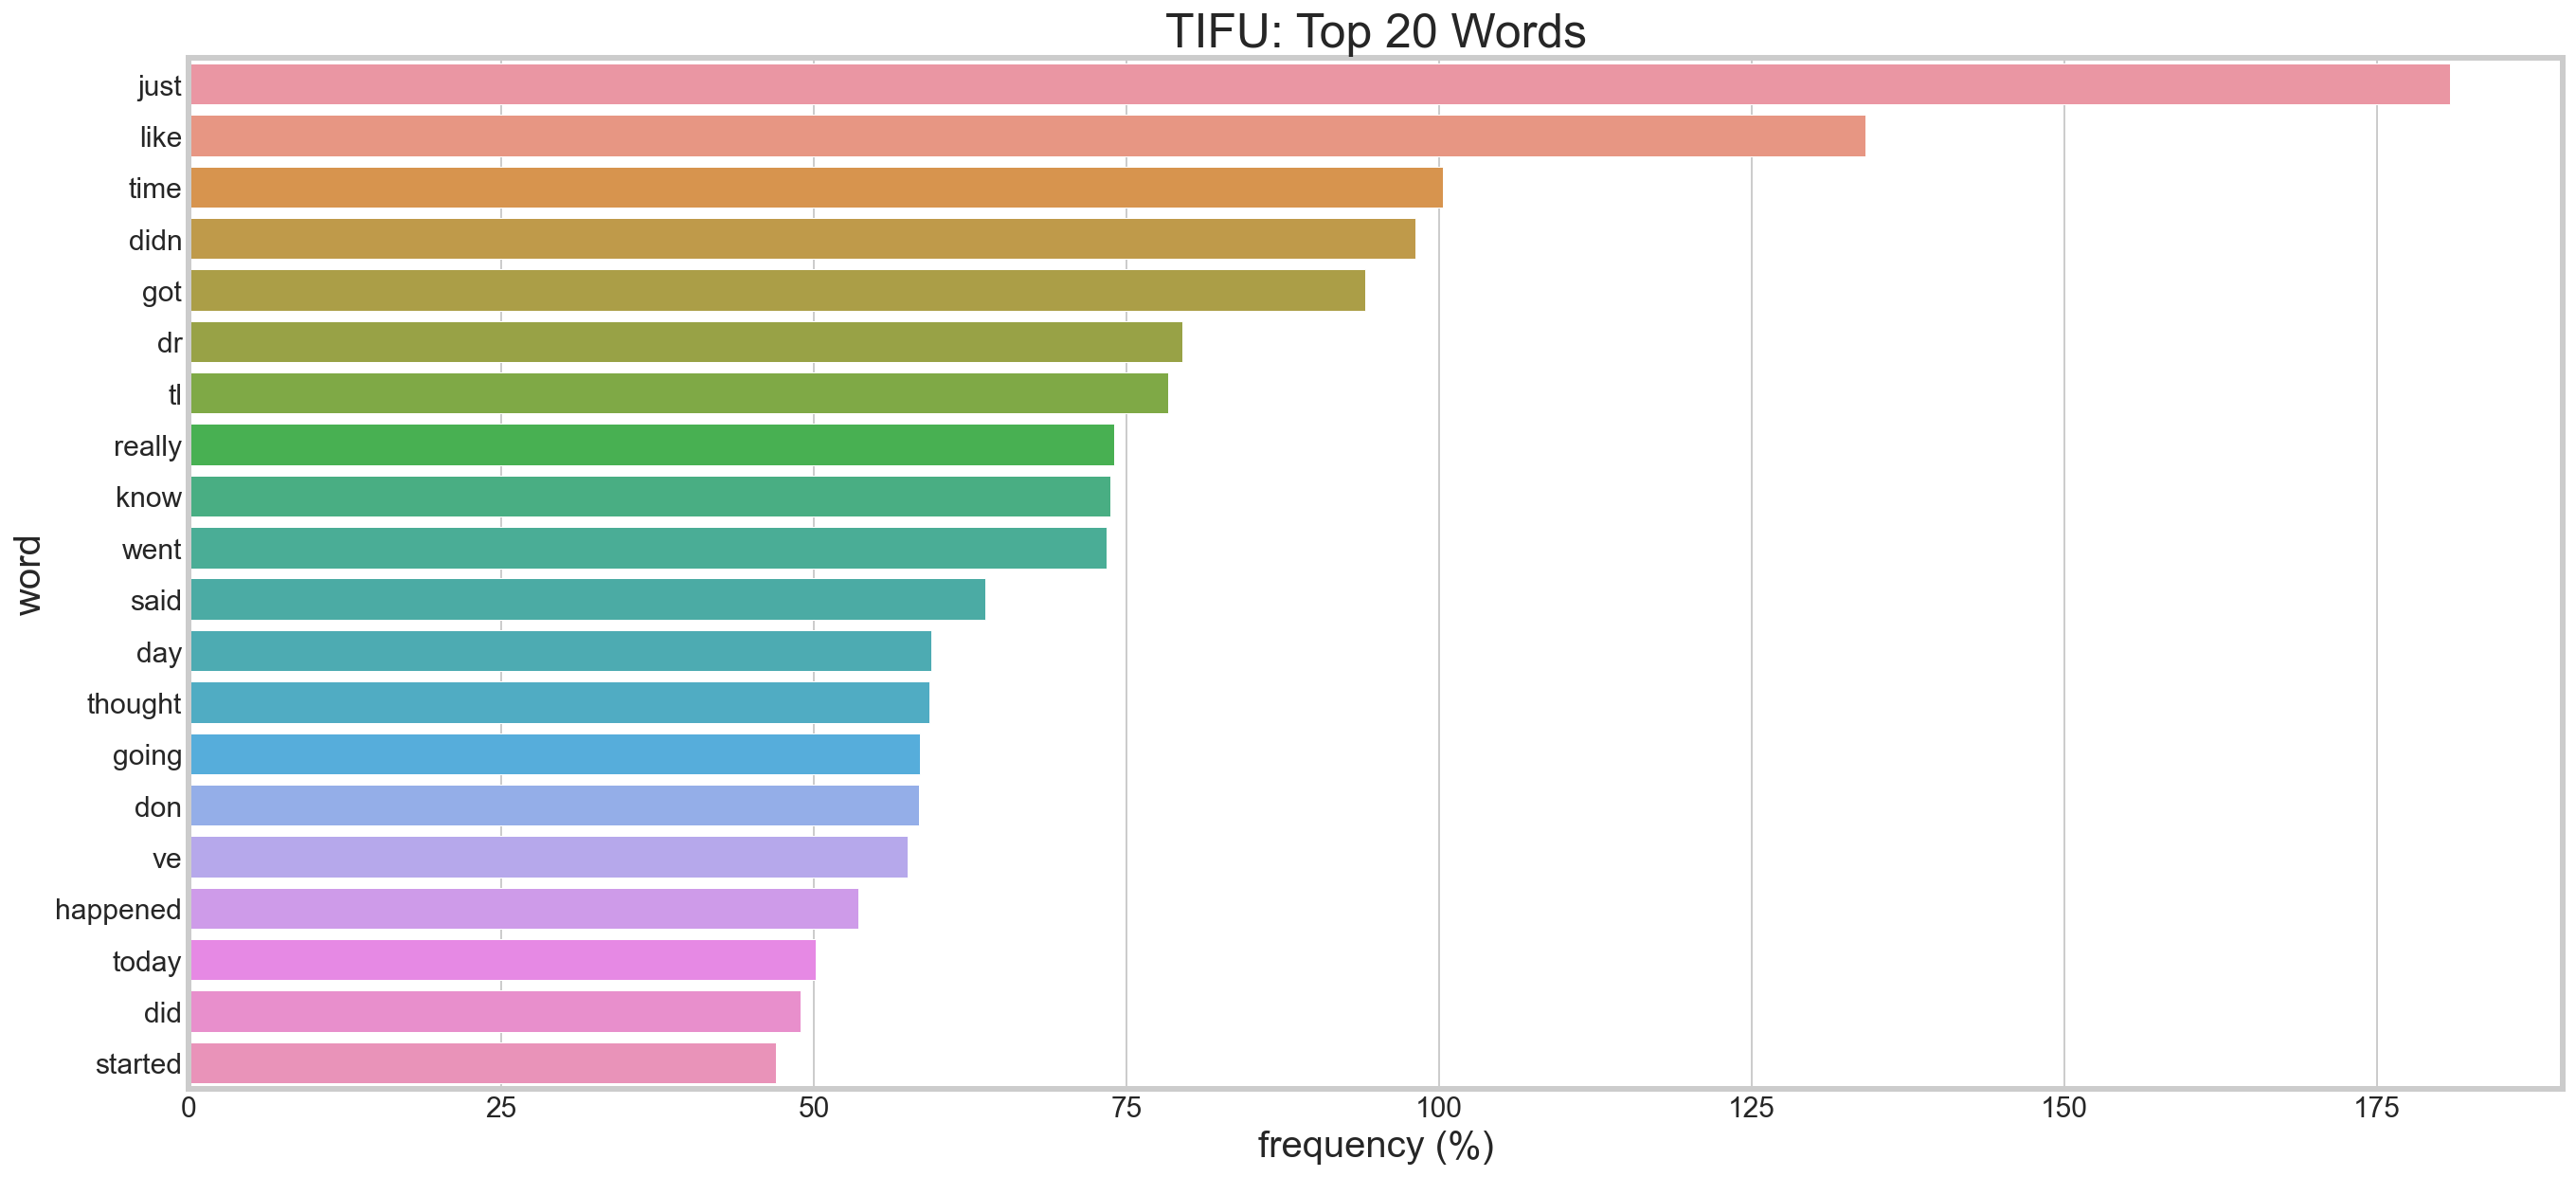

In [57]:
#plot top 20 tifu words, count
plt.figure(figsize=(20,10))
plt.title('TIFU: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_tf.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)



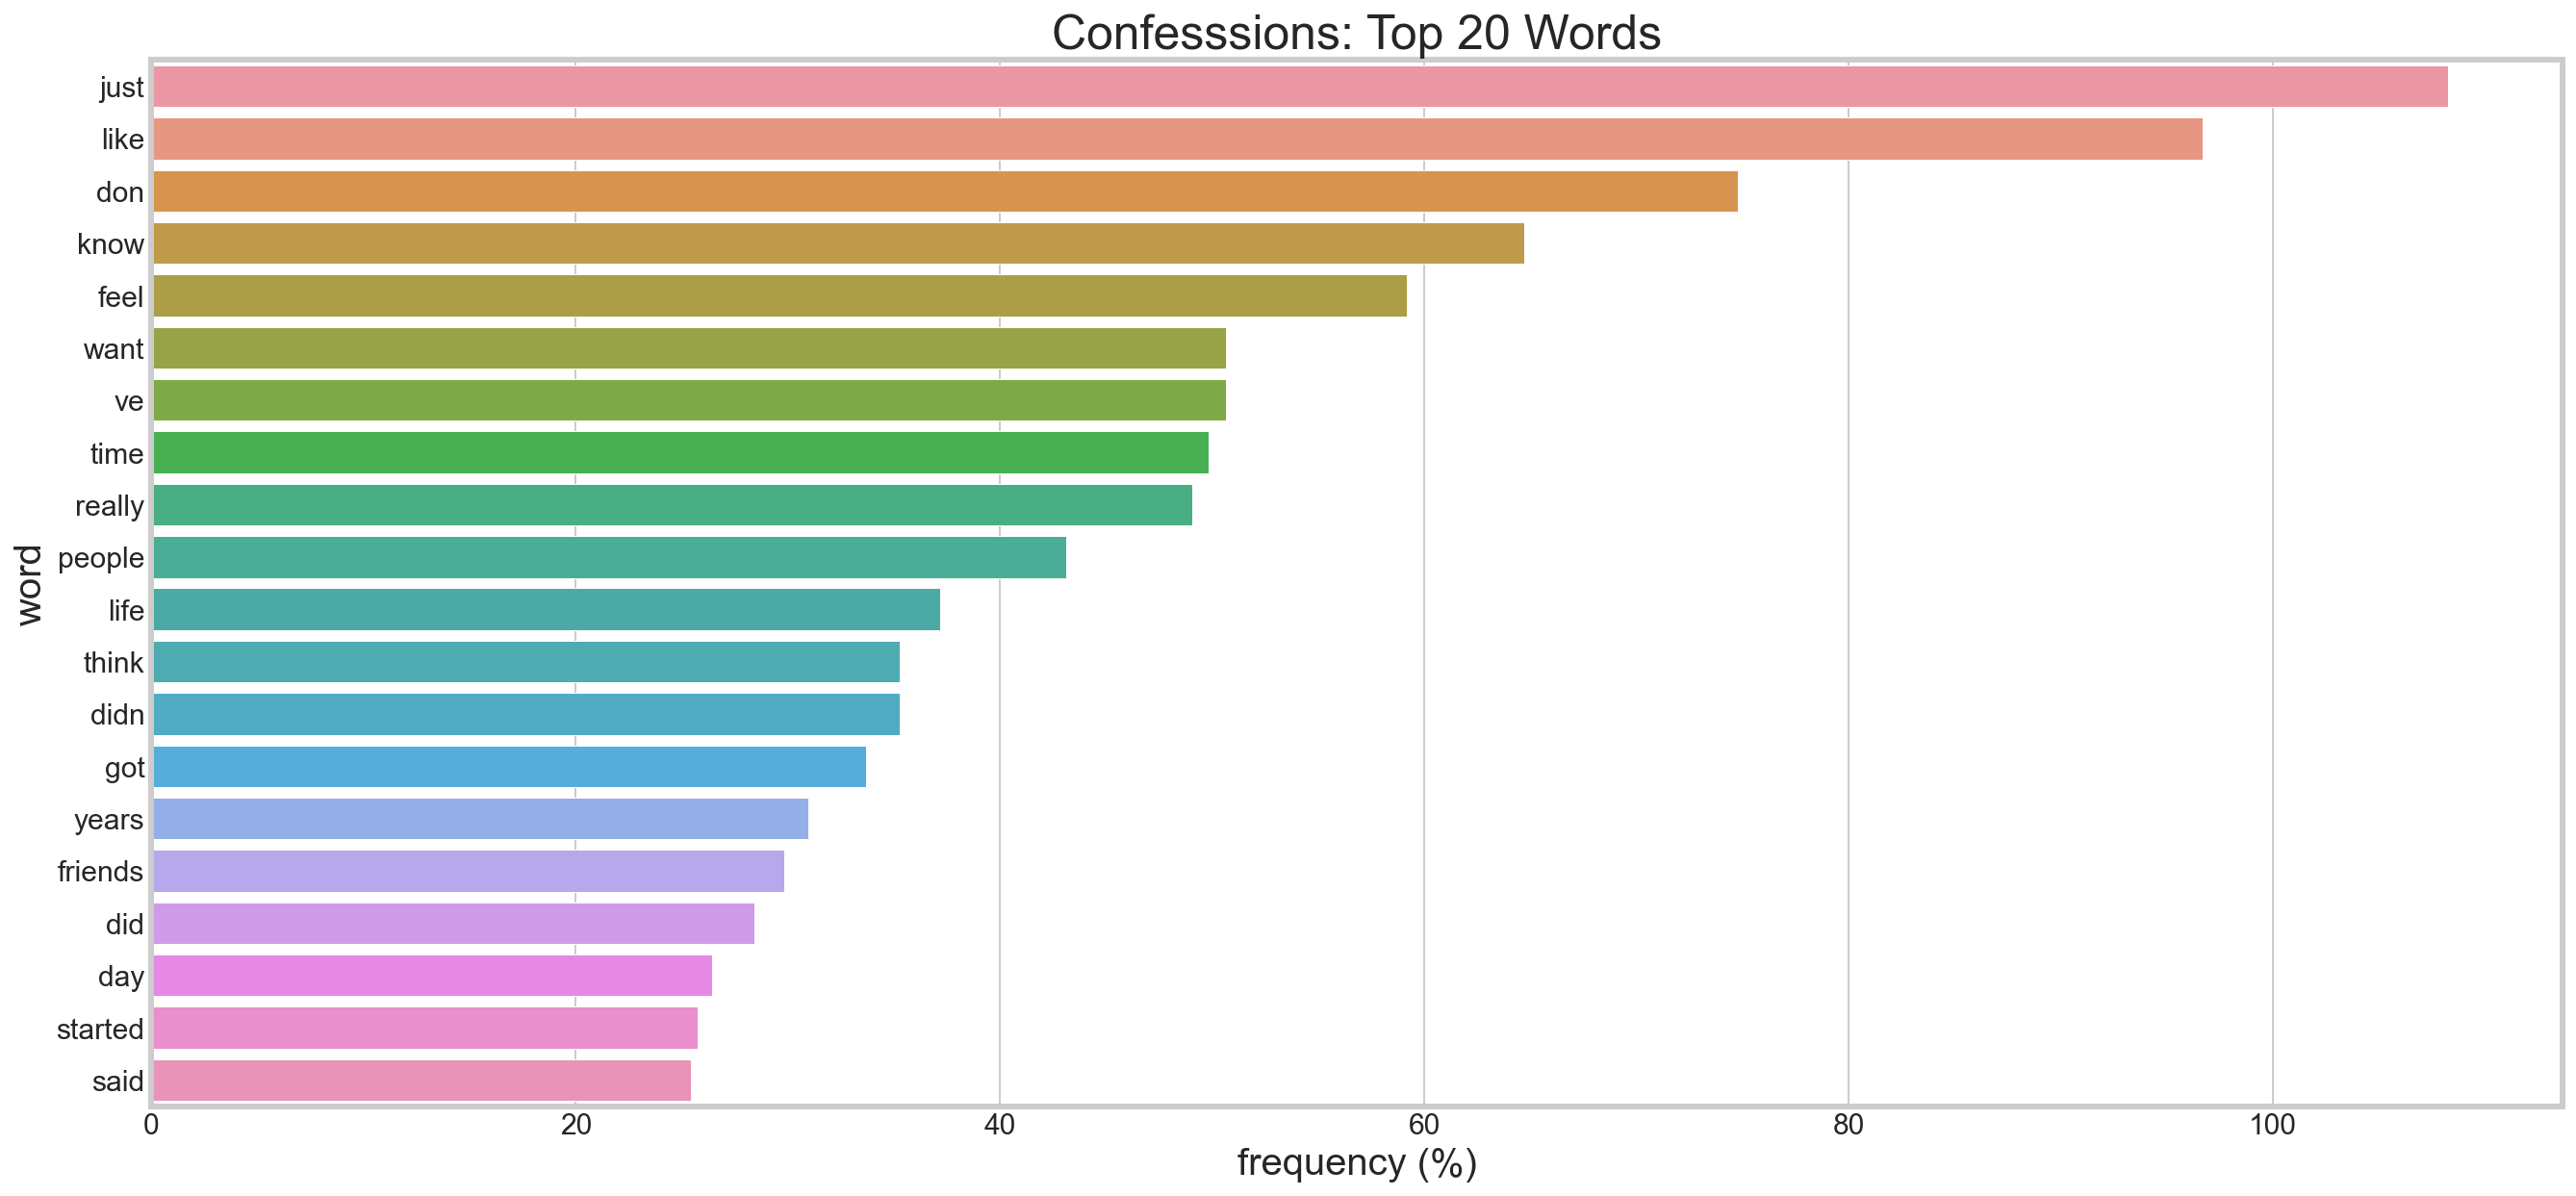

In [58]:
#plot cfns top 20 words, count
plt.figure(figsize=(20,10))
plt.title('Confesssions: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_cfns.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

The top 20 words for both subreddit are similar.

In [240]:
#creating dataframe

tf_df = pd.DataFrame([tf_titles, tf_authors, tf_posts, tf_ups], 
                     index=['title', 'authors', 'posts', 'upvotes'])

cfns_df = pd.DataFrame([cfns_titles, cfns_authors, cfns_posts, cfns_ups], 
                     index=['title', 'authors', 'posts', 'upvotes'])

In [241]:
#Transpose the dataframe
tf_df = tf_df.T

In [242]:
cfns_df = cfns_df.T

In [111]:
tf_df.to_csv('../datasets/tf_df.csv', index = False)
cfns_df.to_csv('../datasets/cfns_df.csv', index = False)

### Data Cleaning

In [119]:
#checking for the nan values
tf_df['title'].isnull().sum()

0

In [120]:
cfns_df['posts'].isnull().sum()

0

In [121]:
#removing the duplicate of posts
tf_df.drop_duplicates(subset='title', inplace = True)
cfns_df.drop_duplicates(subset='title', inplace = True)

In [122]:
print(len(tf_df))

595


In [118]:
print(len(cfns_df))

887


In [129]:
#giving an identity before concat
tf_df['tifu'] = 1
cfns_df['tifu'] = 0

In [130]:
#combine both dataframe
df = pd.concat([tf_df, cfns_df])

In [131]:
#adding new column into the datadframe 
df['content'] = df['title'] + ' ' + df['posts']

In [132]:
df.shape

(1482, 6)

In [133]:
df.head()

,title,authors,posts,upvotes,tifu,content
0,TIFU by accidentally hitting on a customer,t2_3q0ykzzz,Not a long story but as a new years resolution...,4869,1,TIFU by accidentally hitting on a customer Not...
1,TIFU by making someone think I was going to mu...,t2_azh6y,This just happened and I can't believe I didn'...,22880,1,TIFU by making someone think I was going to mu...
2,TIFU by having my husband examine me,t2_8gfpn13y,This happened last night.\n\nI am seven months...,9895,1,TIFU by having my husband examine me This happ...
3,TIFU by taking a new dose of ADHD medication a...,t2_9rkodgxe,"TIFU. Yes, today. Just now. I am still trying ...",387,1,TIFU by taking a new dose of ADHD medication a...
4,Tifu by sitting too close to the fire to escap...,t2_5rfxegiq,TL/DR down the bottom. \n\nNote: Maybe not sui...,15661,1,Tifu by sitting too close to the fire to escap...


In [135]:
df.to_csv('../datasets/tifucofns.csv', index = False, header = True)